### TME sur Echantillonage

## Diffusion dans les graphes 

Au cours des vingt derniÃ¨res annÃ©es, les rÃ©seaux sociaux sont devenus un mÃ©dia dâ€™information incontournable, mettant en jeu des dynamiques complexes de communication entre utilisateurs. La modÃ©lisation de la diffusion dâ€™information sur les rÃ©seaux constitue depuis lors un enjeu majeur, pour diverses tÃ¢ches
telles que lâ€™identification de leaders dâ€™opinions, la prÃ©diction ou la maximisation de lâ€™impact dâ€™un contenu diffusÃ©, la dÃ©tection de communautÃ©s dâ€™opinions, ou plus gÃ©nÃ©ralement lâ€™analyse des dynamiques du rÃ©seau considÃ©rÃ©.

Le modÃ¨le proposÃ© par (Saito et al, 2009) considÃ¨re une diffusion en cascade dans laquelle l'information transite de noeuds en noeuds du rÃ©seau en suivant des relations d'influence entre les utilisateurs. Lorsqu'un utilisateur est ``infectÃ©'' par une information, il possÃ¨de une chance unique de la retransmettre Ã  chacun de ses successeurs dans le graphe, selon une probabilitÃ© dÃ©finie sur le lien correspondant. Le modÃ¨le dÃ©finit en fait deux paramÃ¨tres sur chaque lien $(u,v)$ du graphe:


*   $k_{u,v}$: la probabilitÃ© que l'utilisateur $u$ transmette une information diffusÃ©e Ã  $v$
*   $r_{u,v}$: si la transmission s'effectue, l'utilisateur $v$ la reÃ§oit au temps $t_v=t_u+\delta$, avec $\delta \sim Exp(r_{u,v})$

Pour utiliser ce modÃ¨le, on devra donc Ã©chantillonner selon la distribution exponentielle. Pour commencer, on cherche alors Ã  Ã©crire une mÃ©thode $exp(rate)$ qui Ã©chantillonne des variables d'une loi exponentielle selon le tableau d'intensitÃ©s $rate$ passÃ© en paramÃ¨tre. Cet Ã©chantillonnage se fera par **Inverse Transform Sampling**. Pour Ã©viter les divisions par 0, on ajoutera $1e-200$ aux intensitÃ©s qui valent 0.  


In [1]:
import numpy as np
import math
np.random.seed(0)

def exp(rate):
    rate[rate==0] = math.exp(-200) 
    random = np.random.uniform(0, 1, rate.shape)
    return (-1.0/rate)*np.log(1-random)

#Test
a=exp(np.array([[1,2,3],[4,5,6]]))
for i in range(10000):
    a+=exp(np.array([[1,2,3],[4,5,6]]))
print(a/10000)

# Pour comparaison: 
a=np.random.exponential(1.0/np.array([[1,2,3],[4,5,6]]))
for i in range(10000):
    a+=np.random.exponential(1.0/np.array([[1,2,3],[4,5,6]]))
print(a/10000)


[[0.98796784 0.49198855 0.33501196]
 [0.25022762 0.19644862 0.16723749]]
[[1.00356177 0.50416273 0.34028414]
 [0.25231623 0.20024732 0.16911951]]


VÃ©rification :



```
[[0.98796784 0.49198855 0.33501196]
 [0.25022762 0.19644862 0.16723749]]
[[1.00356177 0.50416273 0.34028414]
 [0.25231623 0.20024732 0.16911951]]
```



Soit le graphe de diffusion donnÃ© ci dessous: 

In [2]:

names={0:"Paul",1:"Jean",2:"Hector",3:"Rose",4:"Yasmine",5:"LÃ©o",6:"Amine",7:"Mia",8:"Quentin",9:"Gaston",10:"Louise"}
k={(0,1):0.9,(1,0):0.9,(1,2):0.2,(2,3):0.5,(3,2):0.4,(2,4):0.9,(4,3):0.9,(1,3):0.5,(2,5):0.5,(5,7):0.7,(1,6):0.2,(6,7):0.1,(1,8):0.8,(8,9):0.2,(1,10):0.5,(10,9):0.9,(8,1):0.8}
r={(0,1):0.2,(1,0):3,(1,2):1,(2,3):0.2,(3,2):0.5,(2,4):10,(4,3):2,(1,3):2,(2,5):0.5,(5,7):15,(1,6):3,(6,7):4,(1,8):0.8,(8,9):0.1,(1,10):12,(10,9):1,(8,1):14}
graph=(names,k,r)


La fonction display_graph ci dessous permet de visualiser le graphe de diffusion correspondant: 

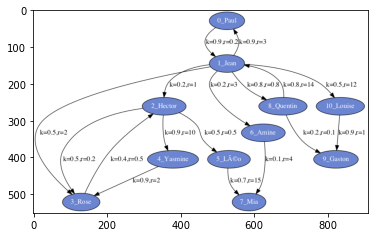

In [3]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

style = { "bgcolor" : "#6b85d1", "fgcolor" : "#FFFFFF" }

def display_graph ( graph_data, style, graph_name="diffusion_graph" ):
    graph = pydot.Dot( graph_name , graph_type='digraph')
    names,k,r=graph_data
    # crÃ©ation des noeuds du rÃ©seau
    for (i,name) in names.items():
        new_node = pydot.Node( str(i)+"_"+name,
                               style="filled",
                               fillcolor=style["bgcolor"],
                               fontcolor=style["fgcolor"] )
        graph.add_node( new_node )

    # crÃ©ation des arcs
    for edge,valk in k.items():
        valr=r[edge]
        n1=str(edge[0])+"_"+names[edge[0]]
        n2=str(edge[1])+"_"+names[edge[1]]
        new_edge = pydot.Edge ( n1, n2, label="k="+str(valk)+",r="+str(valr))
        graph.add_edge ( new_edge )

    # sauvegarde et affichage
    outfile = graph_name + '.png'
    graph.write_png( outfile )
    img = mpimg.imread ( outfile )
    plt.imshow( img )
display_graph(graph,style)

On souhaite Ãªtre capable d'estimer les probabilitÃ©s marginales d'infection des diffÃ©rents utilisateurs du rÃ©seau par une information pour laquelle on connaÃ®t les sources (i.e., les utilisateurs infectÃ©s au temps 0). 

Etant donnÃ©s les cycles possibles dans le graphe de diffusion, considÃ©rer un calcul exact des probabilitÃ©s d'infection des diffÃ©rents utilisateurs sachant le dÃ©but de la diffusion est inenvisageable : il faudrait considÃ©rer toutes les combinaisons possibles (infinies) de temps d'infection pour tous les utilisateurs non sources. 

Une possibilitÃ© pour calculer ces probabilitÃ©s d'infections est de travailler par Ã©chantillonnage de Monte Carlo: on rÃ©alise $n$ tirages d'infections connaissant les sources et on recense le ratio des simulations dans lesquelles chacun des utilisateurs est infectÃ© avant un temps $maxT$.  

L'idÃ©e est alors dans un premier temps d'Ã©crire une mÃ©thode $simulation(graph,sources)$ qui, Ã  partir d'une liste de sources, retourne les temps d'infection de l'ensemble des noeuds en fin de diffusion, sous la forme d'un tableau oÃ¹ chaque case $i$ contient le temps d'infection du noeud $i$. Si le noeud $i$ n'a pas Ã©tÃ© infectÃ© ou bien si il l'a Ã©tÃ© aprÃ¨s un temps maximal $maxT$, la case $i$ contient alors la valeur $maxT$. 

Le pseudo-code de la mÃ©thode de simulation est donnÃ© ci dessous, avec $t_i$ le temps d'infection courant du noeud $i$:
```
ti=maxT pour tout i non source 
Tant qu'il reste des infectieux dont le temps est < maxT:
  i=Infectieux de temps d'infection minimal
  Pour tout noeud j tel que tj>ti:
    sampler x selon Bernouilli(kij)
    si x==1:
       sampler delta selon Exp(rij)
       t=ti+delta  
       si t<tj: tj=t 
  Retrait de i de la liste des infectieux
```
ComplÃ©tez le code de la fonction donnÃ©e ci-dessous: 


In [66]:
maxT=10

# returns dense numpy arrays of k,r parameters for graph links fr -> to 
def get_kr_for(graph,fr,to):
    _,gk,gr=graph
    k=np.array([[gk.get((i, v),0) for v in to] for i in fr])
    r=np.array([[gr.get((i, v),0) for v in to] for i in fr])
    return k,r

def simulation(graph,sources):
    names,gk,gr=graph
    names_ = np.array(list(names.keys()))
    k, r = get_kr_for(graph, names_ , names_)
    
    maxT = 10
    nodes = np.array(list(names.keys()))
#   not_src = np.delete(not_src,[np.where(not_src==sources[i]) for i in range(len(sources)) ])
    
    nodes_copy = nodes.copy()
    t = np.zeros(nodes.shape)
    t = t + maxT 
    t[sources] = 0
    
    t_ = np.zeros(nodes.shape)
    t_ = t_ + maxT 
    t_[sources] = 0
   
    while True:      
        i = np.argmin(t_)
        j_ = np.where(t > t[i])[0]
        j_ = np.delete(j_, np.where(j_==i))
        for j in j_:
            x = np.random.binomial( 1, k[nodes[i],nodes[j]], 1)
            if x == 1: 
                delta = exp(np.array([r[nodes[i], nodes[j]]]))
                tt = t[i] + delta
                if tt < t[j]:
                    t[j] = tt
                    t_[j] = tt
        
        nodes[i] = -1
        t_[i] = maxT + 1
        if np.where(nodes>0)[0].shape[0] == 0:
            break
            
    result = np.zeros(names_.shape)
    result[sources] = 0
    for i in range(nodes.shape[0]):
        result[nodes_copy[i]] = t[i]
    return result
  
np.random.seed(1)
print(simulation(graph,[0]))
print(simulation(graph,[0]))
print(simulation(graph,[0]))
np.random.seed(1)
print(simulation(graph,[0,1]))
print(simulation(graph,[0,1]))
print(simulation(graph,[0,1]))


[ 0.          6.37062627 10.         10.         10.         10.
 10.         10.          6.55971741  8.45768892  6.6581452 ]
[ 0.          2.97007182 10.          3.04941061 10.         10.
 10.         10.          3.63849864  4.45097913  3.06090791]
[ 0.          1.35266305 10.         10.         10.         10.
  1.4157142  10.         10.         10.         10.        ]
[0.00000000e+00 0.00000000e+00 1.00000000e+01 1.00000000e+01
 1.00000000e+01 1.00000000e+01 9.25654159e-03 1.00000000e+01
 1.02250914e+00 1.00000000e+01 1.00000000e+01]
[ 0.          0.         10.         10.         10.         10.
 10.         10.          1.41975241 10.         10.        ]
[ 0.          0.         10.         10.         10.         10.
 10.         10.          1.73693508  0.20332187  0.08144123]


VÃ©rification : 

```
[ 0.          2.71669685 10.         10.         10.         10.
 10.         10.          3.19055869  3.17528764  2.86665883]
[ 0.          0.60940319 10.         10.         10.         10.
 10.         10.          2.36988928 10.         10.        ]
[ 0.          0.22787406 10.         10.         10.         10.
 10.         10.          1.27950225  3.42920125 10.        ]
[ 0.          0.          0.03983788  0.09306264  0.05063365  1.10889995
 10.          1.16647819 10.          1.16739272  0.03159079]
[ 0.          0.         10.         10.         10.         10.
  0.16359844 10.          1.71855838 10.         10.        ]
[ 0.          0.          3.08047501  1.49963044  3.25699405 10.
 10.         10.          0.83189232  2.23597755 10.        ]
```



La mÃ©thode $getProbaMC(graph,sources,nbsimu)$ retourne les estimations de probabilitÃ©s marginales d'infection des diffÃ©rents noeuds de $graph$, conditionnÃ©es Ã  l'observation des  $sources$. Pour Ãªtre enregistrÃ©e, une infection doit intervenir avant la seconde $maxT$. Ainsi, si la mÃ©thode retourne 0.2 pour le noeud $i$, cela indique qu'il a Ã©tÃ© infectÃ© avec un temps $t_i \in ]0,maxT[$ dans 20% des $nbsimu$ simulations effectuÃ©es. ComplÃ©ter la mÃ©thode ci dessous: 

In [72]:
np.random.seed(0)

def getProbaMC(graph,sources,nbsimu=10000):
    maxT = 10
    names_,gk,gr=graph 
    names = np.array(list(names_.keys()))
    result = np.zeros(names.shape)
     
    for i in range(nbsimu):  
        simul = simulation(graph,sources)  
        for name in names: 
            if simul[name] < maxT and simul[name] > 0:
                result[name] = result[name] + 1
    result = result/nbsimu
    result[sources] = 1
    return result
rInf=getProbaMC(graph,[0])
print(rInf) 

rInf=getProbaMC(graph,[0])
print(rInf)

rInf=getProbaMC(graph,[0,1])
print(rInf)  

rInf=getProbaMC(graph,[2,8])
print(rInf) 


[1.     0.7789 0.2555 0.4471 0.2274 0.1089 0.1529 0.0873 0.591  0.3621
 0.3852]
[1.     0.7833 0.2626 0.4487 0.2325 0.1166 0.1616 0.0932 0.5927 0.3592
 0.3872]
[1.     1.     0.3652 0.5974 0.3297 0.1748 0.1998 0.1435 0.8076 0.4988
 0.4924]
[0.7173 0.7955 1.     0.9367 0.9001 0.4929 0.1608 0.3567 1.     0.4421
 0.3996]


VÃ©rification : 


```
[1.      0.7785  0.25939 0.44694 0.23214 0.11123 0.15518 0.09145 0.58973
 0.36455 0.38976]
[1.      0.77994 0.25928 0.44709 0.23307 0.11118 0.155   0.09067 0.59052
 0.36201 0.38788]
[1.      1.      0.35724 0.58993 0.32084 0.17582 0.20088 0.13995 0.79891
 0.49967 0.49876]
[0.71818 0.79804 1.      0.93559 0.89997 0.49813 0.15957 0.35803 1.
 0.44108 0.39904]
```



Cette mÃ©thode permet de bonnes estimations (malgrÃ© une certaine variance) lorsque l'on n'a pas d'observations autres que le vecteur de sources (i.e., on estime des probabilitÃ©s de la forme: $P(t_i < maxT|\{(j,t_j),t_j=0\})$). Par contre, si l'on souhaite obtenir des probabilitÃ©s d'infection du type $P(t_i < maxT|\{(j,t_j),t_j=0\}, \{(j,t_j), j \in {\cal O}\})$, c'est Ã  dire conditionnÃ©es Ã  des observations supplÃ©mentaires pour un sous-ensembles de noeuds ${\cal O}$ (avec $t_j > 0$ pour tout noeud $j$ de ${\cal O}$), l'utilisation de la mÃ©thode de MonteCarlo prÃ©cÃ©dente est impossible. Cela impliquerait de filtrer les simulations obtenues selon qu'elles remplissent les conditions sur les noeuds de ${\cal O}$, ce qui nous amÃ¨nerait Ã  toutes les Ã©carter sachant que l'on travaille avec des temps continus. 

Pour estimer ce genre de probabilitÃ© conditionnelle, nous allons nous appuyer sur des mÃ©thodes de type MCMC, notamment la mÃ©thode de Gibbs Sampling. Cette mÃ©thode est utile pour simuler selon une loi jointe, lorsqu'il est plus simple d'Ã©chantillonner de chaque variable conditionnellement Ã  toutes les autres plutÃ´t que directement de cette loi jointe. L'algorithme est donnÃ© par: 


1.   Tirage d'un vecteur de valeurs initiales pour toutes les variables $X_i$
2.   Pour toutes les variable $X_i$ choisies dans un ordre alÃ©atoire, Ã©chantillonnage d'une nouvelle valeur: $X_i \sim p(x_i\mid x_1,\dots,x_{i-1},x_{i+1},\dots,x_n)$
3.   Recommencer en 2 tant qu'on souhaite encore des Ã©chantillons

Notons qu'il est souvent utile d'exploiter la relation suivante, qui indique que pour Ã©chantillonner de la loi conditionnelle, il suffit d'Ã©chantillonner chaque variable proportionnellement Ã  la loi jointe, avec toutes les autres variables fixÃ©es: 
$$p(x_j\mid x_1,\dots,x_{j-1},x_{j+1},\dots,x_n) = \frac{p(x_1,\dots,x_n)}{p(x_1,\dots,x_{j-1},x_{j+1},\dots,x_n)} \propto p(x_1,\dots,x_n)$$

AprÃ¨s une pÃ©riode dite de $burnin$ d'un nombre d'Ã©poques Ã  dÃ©finir, l'algorithme Ã©met des Ã©chantillons qui suivent la loi jointe connaissant les observations. Lorsque l'objectif est d'estimer des probabilitÃ©s marginales, on fait alors tourner cet algorithme pendant une certain nombre d'Ã©poques aprÃ¨s la pÃ©riode de $burnin$, au cours desquelles on recence les diffÃ©rentes affectations de chacune des variables Ã©tudiÃ©es. 

Pour mettre en oeuvre cet algorithme, nous aurons aurons besoin d'avoir accÃ¨s rapidement aux prÃ©decesseurs et successeurs dans le graphe. La mÃ©thode ci-dessous retourne un couple de dictionnaires Ã  partir du graphe: 
 

*   $preds[i]$  contient la liste des prÃ©dÃ©cesseurs du  noeud $i$, sous la forme d'une liste de triplets $(j,k_{j,i},r_{j,i})$ pour tous les $j$ prÃ©cÃ©dant $i$ dans le graphe.    
*   $succs[i]$  contient la liste des successeurs du  noeud $i$, sous la forme d'une liste de triplets $(j,k_{i,j},r_{i,j})$ pour tous les $j$ pointÃ©s par $i$ dans le graphe.





In [73]:
def getPredsSuccs(graph):
    names,gk,gr=graph
    nbNodes=len(names)
    preds={}
    succs={}
    for (a,b),v in gk.items():
        s=succs.get(a,[])
        s.append((b,v,gr[(a,b)]))
        succs[a]=s
        p=preds.get(b,[])
        p.append((a,v,gr[(a,b)]))
        preds[b]=p
    return (preds,succs)
preds,succs=getPredsSuccs(graph)
print("preds=",preds)
print("succs=",succs)

preds= {1: [(0, 0.9, 0.2), (8, 0.8, 14)], 0: [(1, 0.9, 3)], 2: [(1, 0.2, 1), (3, 0.4, 0.5)], 3: [(2, 0.5, 0.2), (4, 0.9, 2), (1, 0.5, 2)], 4: [(2, 0.9, 10)], 5: [(2, 0.5, 0.5)], 7: [(5, 0.7, 15), (6, 0.1, 4)], 6: [(1, 0.2, 3)], 8: [(1, 0.8, 0.8)], 9: [(8, 0.2, 0.1), (10, 0.9, 1)], 10: [(1, 0.5, 12)]}
succs= {0: [(1, 0.9, 0.2)], 1: [(0, 0.9, 3), (2, 0.2, 1), (3, 0.5, 2), (6, 0.2, 3), (8, 0.8, 0.8), (10, 0.5, 12)], 2: [(3, 0.5, 0.2), (4, 0.9, 10), (5, 0.5, 0.5)], 3: [(2, 0.4, 0.5)], 4: [(3, 0.9, 2)], 5: [(7, 0.7, 15)], 6: [(7, 0.1, 4)], 8: [(9, 0.2, 0.1), (1, 0.8, 14)], 10: [(9, 0.9, 1)]}


Pour calculer les probabilitÃ©s conditionnelles, il faut prendre en compte les quantitÃ©s suivantes: 


*   ProbabilitÃ© pour $j$ d'Ãªtre infectÃ© par $i$ au temps $t_j$ connaissant $t_i < t_j$:  
$$\alpha_{i,j}=k_{i,j}r_{i,j} exp(-r_{i,j}(t_j-t_i))$$
*   ProbabilitÃ© pour $j$ de ne pas Ãªtre infectÃ© par $i$ jusqu'au temps $t$:
$$\beta_{i,j}=k_{i,j} exp(-r_{i,j}(t_j-t_i)) + 1 - k_{i,j}$$
*   ProbabilitÃ© pour $j$ d'Ãªtre infectÃ© au temps $t_j$ connaissant les prÃ©decesseurs infectÃ©s avant $t_j$:
$$h_{j}=\prod_{i \in preds[j], t_i<t_j} \beta_{i,j} \sum_{i \in preds[i], t_i<t_j} \alpha_{i,j} / \beta_{i,j}$$
*   ProbabilitÃ© pour $j$ de ne pas Ãªtre infectÃ© avant $maxT$ connsaissant ses prÃ©decesseurs infectÃ©s:
$$g_{j}=\prod_{i \in preds[j], t_i<t_j} \left(k_{i,j} exp(-r_{i,j}(maxT-t_i)) + 1 - k_{i,j}\right)=\prod_{i \in preds[j], t_i<t_j} \beta_{i,j}$$




Dans la mÃ©thode $computeab(v, times, preds)$, on prÃ©pare le calcul et les mises Ã  jour de ces quantitÃ©s. La mÃ©thode calcule, pour un noeud $v$ selon les temps d'infection courants donnÃ©s dans $times$, deux quantitÃ©s $a$ et $b$: 
*   $a= max(1e^{-20}, \sum_{i \in preds[v], t_i<t_v} \alpha_{i,v} / \beta_{i,v})$ si $t_v< maxT$ et $a=1$ sinon. 

*   $b=\sum_{i \in preds[v], t_i<t_v} \log \beta_{i,v}$.

Si $v$ appartient aux sources, on retourne $(a,b)=(1,0)$

ComplÃ©ter la mÃ©thode $computeab$ donnÃ©e ci-dessous:   



In [90]:
eps=1e-20

def computeab(v, times, preds):
    maxT = 10
    preds=preds.get(v,[])
    t=times[v]
    if t==0:
        return (1,0)
    a=eps
    b=0
    if len(preds)>0:
        if(t > maxT):
            a = 1
        else:
            sum = 0
            for pred in preds:       
                if times[pred[0]]< t:
                    kiv = pred[1]
                    riv = pred[2]
                    alpha = kiv*riv*exp(np.array([-riv*(times[pred[0]] - t)]))
                    beta = kiv*exp(np.array([-riv*(times[pred[0]] - t)])) + 1 - kiv
                    sum = sum + alpha/beta
            
            if sum[0] > a:
                a = sum[0]
            
        sum = 0
        for pred in preds:       
            if times[pred[0]]< t:
                kiv = pred[1]
                riv = pred[2]
                beta = kiv*exp(np.array([-riv*(times[pred[0]] - t)])) + 1 - kiv
                sum = sum + np.log(beta)
        b = sum[0]
    
    return (a,b)
np.random.seed(0)
nbNodes=len(graph[0])
times=np.array([maxT]*nbNodes,dtype=float)
times[0]=0
times[1]=1
times[2]=4

print(computeab(0,times,preds))
print(computeab(1,times,preds))
print(computeab(2,times,preds))
print(computeab(3,times,preds))


(1, 0)
(0.12453509358991323, 1.447978223182849)
(0.06271995147463262, -0.14016981293070277)
(0.39230826043332967, -0.5092025790388879)


VÃ©rification : 


```
(1, 0)
(0.17610107365772135, -0.17810126145719926)
(0.012293749653343877, -0.2107736084094422)
(1.0, -1.12301187855188)
```



La mÃ©thode $computell$ calcule la log-vraisemblance d'une diffusion (reprÃ©sentÃ©e par le tableau times), en appelant la mÃ©thode computeab sur l'ensemble des noeuds du rÃ©seau. Elle retourne un triplet (log-likelihood, sa, sb), avec $sa$ et $sb$ les tables des valeurs $a$ et $b$ pour tous les noeuds.   

In [ ]:
def computell(times,preds):
  #>>>>>>
  # votre code ici
  #<<<<<

ll,sa,sb=computell(times,preds)
print("ll=",ll)
print(times)
print("like_indiv=",np.exp(np.log(sa)+sb))


VÃ©rification : 



```
ll= -13.117139892397578
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
like_indiv= [1.         0.14737154 0.00995741 0.32529856 0.1        0.52489353
 0.8        1.         0.20059727 1.         0.5       ]
```



Afin de prÃ©parer les mises Ã  jour lors des affectations successives des variables du Gibbs Sampling, on propose de dÃ©finir une mÃ©thode $removeV(v,times,succs,sa,sb)$ qui retire temporairement du rÃ©seau un noeud $v$, en passant son temps d'infection Ã  -1 dans times et en retirant sa contribution aux valeurs a et b (contenues dans sa et sb) de tous ses successeurs $j$ tels que $t_j > t_v$ (y compris donc les non infectÃ©s qui sont Ã  $t_j=maxT$). 

In [ ]:
def removeV(v,times,succs,sa,sb):
  succs=succs.get(v,[])
  t=times[v]
  if t<0:
    return 
  times[v]=-1
  sa[v]=1.0
  sb[v]=0.0
  if len(succs)>0:
    c,k,r=map(np.array,zip(*succs))
    tp=times[c]
    which=(tp>t)

    tp=tp[which]
    dt=tp-t
    k=k[which]
    r=r[which]
    c=c[which]
    rt = -r*dt
    b1=k*np.exp(rt)
    b=b1+1.0-k
    
    a=r*b1
    a=a/b
    b=np.log(b)
    
    sa[c]=sa[c]-np.where(tp<maxT,a,0.0)
    sa[c]=np.where(sa[c]>eps,sa[c],eps)
    sb[c]=sb[c]-b
    sb[c]=np.where(sb[c]>0,0,sb[c])


#Test
print("sa=",sa)
print("sb=",sb)

nsa=np.copy(sa)
nsb=np.copy(sb)
ntimes=np.copy(times)
removeV(3,ntimes,succs,nsa,nsb)
print("diffa=",nsa-sa)
print("diffb=",nsb-sb)

nsa=np.copy(sa)
nsb=np.copy(sb)
ntimes=np.copy(times)
removeV(1,ntimes,succs,nsa,nsb)
print("diffa=",nsa-sa)
print("diffb=",nsb-sb)


La mÃ©thode addVatT fait l'inverse: elle rajoute un noeud qui Ã©tait retirÃ© du rÃ©seau, avec un temps $newt$. Il faut alors mettre Ã  jour les valeurs a et b (dans sa et sb) de tous les successeurs de $v$ tels que $t_j > newt$ et calculer les valeurs a et b du noeud v. 

ComplÃ©ter le code ci-dessous: 

In [ ]:
def addVatT(v,times,newt,preds,succs,sa,sb):
  t=times[v]
  if t>=0:
    raise Error("v  must have been removed before")
  
  #>>>>>>>>>>>>
  # votre code ici
  #<<<<<<<<<<<<<<<<<<<

# Tests: 
   
nsa=np.copy(sa)
nsb=np.copy(sb)
c,_,_=map(np.array,zip(*succs[1]))
c=np.append(c,1)
ll=np.sum((np.log(nsa)+nsb)[c])           # somme des logvraisemblances pouvant Ãªtre modifiÃ©es par la modification du temps de 1 (avant modif)
removeV(1,times,succs,nsa,nsb)
addVatT(1,times,2,preds,succs,nsa,nsb)
ll2=np.sum((np.log(nsa)+nsb)[c])          # somme des logvraisemblances pouvant avoir Ã©tÃ© modifiÃ©es par la modification du temps de 1 (aprÃ¨s modif)
removeV(1,times,succs,nsa,nsb)
addVatT(1,times,1,preds,succs,nsa,nsb)
ll3=np.sum((np.log(nsa)+nsb)[c])          # somme des logvraisemblances pouvant  avoir Ã©tÃ© modifiÃ©es par la modification du temps de 1 (aprÃ¨s remise dans l'Ã©tat initial)
llall=np.sum(np.log(nsa)+nsb)             # logvraisemblance globale
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

c,_,_=map(np.array,zip(*succs[0]))
c=np.append(c,0)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(0,times,succs,nsa,nsb)
addVatT(0,times,maxT,preds,succs,nsa,nsb)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(0,times,succs,nsa,nsb)
addVatT(0,times,0,preds,succs,nsa,nsb)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

c,_,_=map(np.array,zip(*succs[5]))
c=np.append(c,5)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(5,times,succs,nsa,nsb)
addVatT(5,times,1,preds,succs,nsa,nsb)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(5,times,succs,nsa,nsb)
addVatT(5,times,maxT,preds,succs,nsa,nsb)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)



VÃ©rification : 



```
3.830251606174211e-05 8.555487921315824e-05 3.830251606174211e-05 -13.117139892397578
0.14737153555403676 1.0000000000169125e-21 0.14737153555403676 -13.117139892397578
0.5248935341839319 2.999999999999998e-21 0.5248935341839319 -13.117139892397578
```



Pour Ã©chantillonner pour une variable $i$, il faudra Ãªtre Ã  mÃªme de comparer les vraisemblances selon les diffÃ©rentes affectations. Cela implique de calculer la somme de toutes ces vraisemblances. Mais pour rÃ©aliser cette somme, il faudrait que nous sortions de la reprÃ©sentation logarithmique: $\sum_{t_i} exp(log(p(t_1,\dots,t_i,\dots,t_n))$. Si on le fait de cette maniÃ¨re, on risque d'avoir des arrondis Ã  0 presque partout. Une possibilitÃ© (log-sum-exp trick) est d'exploiter la relation suivante:  

$$\log\sum_i x_i = x^* + \log\left( \exp(x_1-x^*)+ \cdots + \exp(x_n-x^*) \right)$$
avec $x^* = \max{\{x_1, \dots, x_n\}}$

ComplÃ©ter la mÃ©thode logsumexp suivante, qui rÃ©alise cette somme en Ã©vitant les problÃ¨mes numÃ©riques: 


In [ ]:
def logsumexp(x,axis=-1):
  #>>>>>>>>>>
  # votre code ici
  #<<<<<<<<<<
  return x
  

#Test: 
x=np.array([[0.001,0.02,0.008],[0.1,0.01,0.4]])
r=np.log(np.sum(x,-1))
x=np.log(x)
r2=logsumexp(x)
print(r2,r)



VÃ©rification : 


```
[-3.54045945 -0.67334455] [-3.54045945 -0.67334455]
```



On souhaite maintenant mettre en place une mÃ©thode $sampleV(v,times,newt,preds,succs,sa,sb,k,k2)$ qui sample un nouveau temps d'infection pour le noeud $v$, connaissant les temps de tous les autres noeuds dans $times$ (ainsi que leurs valeurs $a$ et $b$ correspondantes contenues dans sa et sb). Puisque le domaine de support de $t_v$ est continu, on doit faire quelques approximations en se basant sur une discrÃ©tisation des valeurs possibles:

1.   On dÃ©coupe la plage de temps $[0;maxT]$ en $k$ bins rÃ©guliers. Dans chaque bin $i$, on Ã©chantillonne uniformÃ©ment un temps, pour obtenir $k$ points $d_1,\dots,d_k$. Si $t_v < maxT$, on ajoute $t_v$ Ã  cet ensemble de points pour gagner en stabilitÃ© (insÃ©rÃ© dans la liste de maniÃ¨re Ã  conserver l'ordre croissant). 
2.   On considÃ¨re chaque point $d_i$ comme le prototype d'un bin $[(d_i+d_{i-1})/2,(d_i+d_{i+1})/2]$. Pour $d_1$ on prend $[0,(d_1+d_2)/2]$ et pour $d_k$ on prend   $[(d_k+d_{k-1})/2,maxT]$. On fait l'hypothÃ¨se que la densitÃ© de probabilitÃ© est constante sur l'ensemble de chaque bin $i$, que l'on Ã©value en  $t_v=d_i$.   La probabilitÃ© que l'on Ã©chantillonne dans le bin $i$ est alors Ã©gale Ã : $p(t_v \in bin_i | \{t_u\}_{ u \in V\setminus v}) =  \frac{z_i \times l_i}{\sum_j z_j \times l_j + z_{maxT}}$, avec $z_i$ la vraisemblance  calculÃ©e selon $t_v =d_i$, $l_i$ la taille du bin $i$ et $z_{maxT}$ la vraisemblance  calculÃ©e pour $t_v=maxT$. La probabilitÃ© que $v$ ne soit pas infectÃ© dans la diffusion est alors donnÃ©e par : $p(t_v = maxT | \{t_u\}_{ u \in V\setminus v}) =  \frac{z_{maxT}}{\sum_j z_j \times l_j + z_{maxT}}$.
3. On Ã©chantillonne une variable $x$ proportionnellement aux probabilitÃ©s calculÃ©es Ã  l'Ã©tape prÃ©cÃ©dente.  Si $x$ ne correspond pas Ã  $maxT$, $v$ est alors infectÃ© Ã  un temps inclus dans l'intervale du bin correspondant Ã  $x$. Il s'agit alors de re-Ã©chantillonner $k2$ points uniformÃ©ment dans ce bin et de calculer les densitÃ©s en ces points (pour gagner en stabilitÃ© on ajoute le prototype du bin $d_i$). Le nouveau temps de $v$ est alors Ã©chantillonnÃ© proportionnellement Ã  ces densitÃ©s.

Le code de la mÃ©thode de sampling est donnÃ© ci-dessous:





In [ ]:
np.random.seed(0)



def getLL(v,times,nt,preds,succs,sa,sb,onUsers=None):
  sa=np.copy(sa)
  sb=np.copy(sb)
  if onUsers is None:
    onUsers=range(len(times))
  addVatT(v,times,nt,preds,succs,sa,sb)
  times[v]=-1
  ll=np.sum((np.log(sa)+sb)[onUsers])
  return (ll,sa,sb)

  
def sampleV(v,times,preds,succs,sa,sb,k,k2):
  
  nbCandidateT=k
  bounds=np.linspace(0,maxT,nbCandidateT)
  newt=np.random.uniform(bounds[:-1],bounds[1:])
  
  if times[v]<maxT:
    idx = newt.searchsorted(times[v])
    newt=np.concatenate((newt[:idx], [times[v]], newt[idx:]),axis=0)
    nbCandidateT+=1
  newt=np.append(newt,[maxT])
  
  if v in succs:
    c,_,_=map(list,zip(*succs.get(v,[])))
  else:
    c=[]
  c.append(v)
  c=np.array(c)
  oldll=np.sum((np.log(sa)+sb)[c])
  otime=times[v]
  nsa=np.copy(sa)
  nsb=np.copy(sb)
  removeV(v,times,succs,nsa,nsb)
  lls=[getLL(v,times,nt,preds,succs,nsa,nsb,onUsers=c) for nt in newt]
  ll,la,lb=zip(*lls)
  ll=list(ll)
  ll=np.array(ll)
  
  diffsx=(newt[1:]-newt[:-1])/2.0
  diffsx[1:]=diffsx[1:]+diffsx[:-1]
  diffsx[0]+=newt[0]
  diffsx[-1]+=(maxT-newt[nbCandidateT-1])/2.0
  areas=np.log(diffsx)+ll[:-1]
  lln=np.append(areas,ll[-1])
  

  p=np.exp(lln-logsumexp(lln))
  
  
  i=np.random.choice(range(len(p)),1,p=p).sum()
  if i==(len(p)-1):
    times[v]=maxT
    np.copyto(sa,np.array(la[-1]))
    np.copyto(sb,np.array(lb[-1]))
  else: 
      if i>0: 
        bi=(newt[i]+newt[i-1])/2.0
      else:
        bi=0
      if i<(len(p)-2): 
        bs=(newt[i]+newt[i+1])/2.0
      else:
        bs=maxT
      bounds=np.linspace(bi,bs,k2)
      newt=np.concatenate(([newt[i]],np.random.uniform(bounds[:-1],bounds[1:])))
      lls=[getLL(v,times,nt,preds,succs,nsa,nsb,onUsers=c) for nt in newt]
      ll,la,lb=zip(*lls)
      ll=np.array(ll)
      p=np.exp(ll-logsumexp(ll))
      
      i=np.random.choice(range(len(p)),1,p=p).sum()
      
      times[v]=newt[i]
      np.copyto(sa,np.array(la[i]))
      np.copyto(sb,np.array(lb[i]))
   
  
times=np.array([maxT]*nbNodes,dtype=float)
times[0]=0
times[1]=1
times[2]=4
np.random.seed(0)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)



VÃ©rification : 



```
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.          1.          4.         10.         10.          4.20931617
 10.         10.         10.         10.         10.        ]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
```



ComplÃ©ter la mÃ©thode de Gibbs Sampling $gb$ ci-dessous, avec $k$ le nombre de bins Ã  utiliser et $k2$ le nombre de points Ã  Ã©chantillonner dans le bin choisi. Le paramÃ¨tre $ref$ correspond Ã  un vecteur de probabilitÃ©s marginales de rÃ©fÃ©rence (par exemple obtenu par MonteCarlo lorsque c'est possible) avec lequel on peut afficher la distance MSE au fur et Ã  mesure du processus.

In [ ]:

np.random.seed(1)
def gb(graph,infections,burnin=1000,nbEpochs=10000,k=100,k2=50, ref=None):
   #>>>>>>>>>>>>>>>>>>>>>>>
   # votre code ici
   #>>>>>>>>>>>>>>>>>>>>>>>>>>
   return rate

# On teste ici avec seulement des sources (i.e., des infectÃ©s au temps 0), car cela permet de comparer Ã  la ref MonteCarlo (mais il faudrait aussi tester avec d'autres infectÃ©s : c'est l'objectif). 
ref=getProbaMC(graph,[0]) 
rate=gb(graph,[(0,0)],burnin=100,ref=ref)
print(rate)



# Partie optionnelle

L'algorithme de Metropolis-Hasting est une autre mÃ©thode de type MCMC qui utilise une distribution d'Ã©chantillonnage pour se dÃ©placer dans l'espace des points considÃ©rÃ©s. Il s'agit de dÃ©finir une distribution $q(y_{t+1}|x_t)$ de laquelle on sait gÃ©nÃ©rer un dÃ©placement. L'algorithme procÃ©de alors de la maniÃ¨re suivante: 


1.   GÃ©nÃ©rer $y_{t+1}$ selon $q(y_{t+1}|x_t)$ 
2.   Calculer la probabilitÃ© dâ€™acceptation $\alpha(x_t,y_{t+1})=\min\left\{\frac{\pi(y_{t+1})q(x_t|y_{t+1})}{\pi(x_t)q(y_{t+1}|x_t)},1\right\} \,\!, \text{ avec } \pi(x_t) \text{ la densitÃ© de probabilitÃ© de } x_t$
3.   Prendre $x_{t+1}=\begin{cases} y_{t+1}, & \text{avec probabilitÃ©}\,\,\alpha \\ x_t, & \text{avec probabilitÃ©}\,\,1-\alpha \end{cases}$



Dans notre cas, on propose de travailler avec des dÃ©placements correspondants Ã  des permutations d'un temps d'infection Ã  chaque itÃ©ration, comme dans le cadre du Gibbs Sampling. A chaque Ã©tape on choisit donc une variable Ã  modifier, on choisit un nouveau temps pour cette variable et on calcule la densitÃ© correspondante. La probabilitÃ© d'acceptation est ensuite calculÃ©e selon cette densitÃ© et la probabilitÃ© du dÃ©placement selon la distribution $q$ qui a servi Ã  gÃ©nÃ©rer le nouveau temps d'infection. On se propose de choisir $maxT$ avec une probabilitÃ© de 0.1. La probabilitÃ© $q(t_v|t)$ pour $t< maxT$ est alors Ã©gale  Ã   $0.9\times \frac{1}{maxT}$.

ImplÃ©menter l'approche d'Ã©chantillonnage par Metropolis-Hasting pour notre problÃ¨me d'estimation de probabilitÃ©s marginales d'infection. 

In [ ]:
# votre code ici

ref=getProbaMC(graph,[0]) 
rate=mh(graph,[(0,0)],burnin=100,ref=ref)
print(rate)